<a href="https://colab.research.google.com/github/ckameron99/3F4/blob/main/3F4lab_release.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 3F4 Lab on Convolutional Coding and Decoding

Welcome to the new 3F4 lab on convolutional coding and decoding. In this lab we aim to learn the following:

1. Encoder:
  * Convert from octal notation
  * Encoding a binary data stream
2.  Graphs:
  * How to store graphs as data structures in Python
  * Build the state diagram graph of a convolutional code
  * Build a trellis graph for a convulutional code
3. Error performance:
  * Compute the distance spectrum
  * Bound the error probability
4. Decoders:
  * Implement a Viterbi decoder
  * Implement a BCJR decoder
  * Simulate and investigate coding system performance
5. Looking further:
  * Turbo coding
  * Channels with insertions and deletions (with applications to DNA alignment)



## 1. Encoder

In order to convert between octal notation and binary, we first need a function to convert from a number in one base to a number in another base. Here, we consider "number" to be a list of numbers where the last number in the list is the least significant number. This should do the trick:


In [ ]:
def base2number(x,b):
  # "numbers" are stored as lists, MSB first
  # compute the number x in base b
  number = 0
  q = 1
  for k in reversed(x):
    # =====> insert missing commands here
  return(number)

def number2base(x,b,length=None):
  y = []
  while x:
    # =====> insert missing commands here
  if length != None:
    y.extend([0]*(length-len(y)))
  return(y[::-1]) # reverse output vector to MSB -> LSB

def base2base(x,b1,b2):
  number = base2number(x,b1)
  return(number2base(number, b2))

Now let's try this out to convert a convolutional code described in octal notation to binary "polynomial" vectors. For example, take the $(15,17)_8$ convolutional code:

In [ ]:
p1 = base2base([1,5],8,2)
p2 = base2base([1,7],8,2)
print(p1)
print(p2)
print(number2base(5,2))
print(number2base(5,2,5))

[1, 1, 0, 1]
[1, 1, 1, 1]
[1, 0, 1]
[0, 0, 1, 0, 1]


Now we need an encoder that takes a convolutional code description in octal and generates a stream of output data for a given stream of output data. This should do the trick:

In [ ]:
def conv_encode_symbol(input_symbol, binary_polynomials, state=None):
  if state==None:
    state = [0]*(max([len(p) for p in binary_polynomials])-1)
  state.insert(0,input_symbol)
  output = []
  for k in range(len(binary_polynomials)):
    # ======> insert missing command here
  state.pop()
  return output, state

def conv_encode_list(input_list, octal_polynomials, terminated = True):
  binary_polynomials = []
  for p in octal_polynomials:
    binary_polynomials.append(base2base(p,8,2))
  output, state = conv_encode_symbol(input_list[0],binary_polynomials)
  for input_symbol in input_list[1:]:
    new_output,state = conv_encode_symbol(input_symbol,binary_polynomials,state)
    output.extend(new_output)
  if (terminated == True):
    for n in range(len(state)):
      # ======> insert missing commands here
  return(output)

Let's test this for a n input symbol and for a short input list:

In [ ]:
[out,state] = conv_encode_symbol(1,[[1,0,1],[1,1,1]],[1,1])
print(out)
print(state)

out = conv_encode_list([0,1,0,1,1],[[5],[7]])
print(out)



[0, 1]
[1, 1]
[0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1]


## 2. Graphs

We now explore data structures that can store graphs in Python and use this to store a convolutional code's state diagram and trellis. 

A basic graph in python can be stored as a dictionary of nodes where each node stores a list of nodes it is connected to. For a directed graph (the only sort of graph we ware interested in in our context) we can separate this into a list of forward and backward nodes. 

Here is an example of a class that would implement such a graph, and an example of a small graph:

In [ ]:
class graph_node:
  def __init__(self, name="", forward_nodes=[], backward_nodes=[]):
    self.name = name
    self.forward_nodes = forward_nodes
    self.backward_nodes = backward_nodes
  def __str__(self):
    return f"Name: {self.name}, Forward nodes: {self.forward_nodes}, Backward nodes: {self.backward_nodes}"
  
n1=graph_node(0,[1,2],[3])
n2=graph_node(1,3,0)
n3=graph_node(2,3,0)
n4=graph_node(3,0,[1,2])

print(n1)
print(n2)
print(n3)
print(n4)

Name: 0, Forward nodes: [1, 2], Backward nodes: [3]
Name: 1, Forward nodes: 3, Backward nodes: 0
Name: 2, Forward nodes: 3, Backward nodes: 0
Name: 3, Forward nodes: 0, Backward nodes: [1, 2]


However, the representation of a graph at this level is rather clonky. While establishing a data structure to store and work with graphs is simple in Python, drawing a graph is a different matter and requires some advanced programming skills. Hence, if we want to visualise our graphs we are better off importing a library that does it for us. There are several graphing libraries available in Python and we explored two in particular:
*  igraph 
*  NetworkX

I decided to use the first of the two (mainly because I liked that its name is in lower case). 

Here is the graph above stored and drawn using igraph:


In [ ]:
!pip install igraph
import igraph as ig
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.2 MB/s eta 0:00:00


<AxesSubplot:>

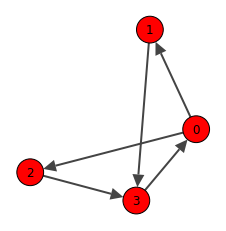

In [ ]:
dummy_graph = ig.Graph(edges=[(0,1),(0,2),(1,3),(2,3),(3,0)],directed=True)
ig.plot(dummy_graph,vertex_label=range(dummy_graph.vcount()),target=plt.axes())

We can now build a function that draws the state diagram of a convolutional code as an igraph. Let us start with the $(5,7)_8$ code that we know from the lectures. 

In [ ]:
def conv_state_diagram(octal_polynomials):
  binary_polynomials = []
  for p in octal_polynomials:
    binary_polynomials.append(base2base(p,8,2))
  output, state = conv_encode_symbol(0, binary_polynomials)
  L = len(state)
  n_vertices = 2**L
  g = ig.Graph(n_vertices, directed=True)
  for in_vertex in range(n_vertices):
    state=number2base(in_vertex,2,L)
    g.vs[in_vertex]["name"] = ''.join(str(n) for n in state)
    for input_symbol in [0,1]:
      state=number2base(in_vertex,2,L)    
      output,state = conv_encode_symbol(input_symbol,binary_polynomials,state)
      out_vertex = base2number(state,2)
      new_edge = g.add_edge(in_vertex,out_vertex)
      new_edge["name"] = f"{str(input_symbol)}/{''.join(str(n) for n in output)}"
  return(g)

<AxesSubplot:>

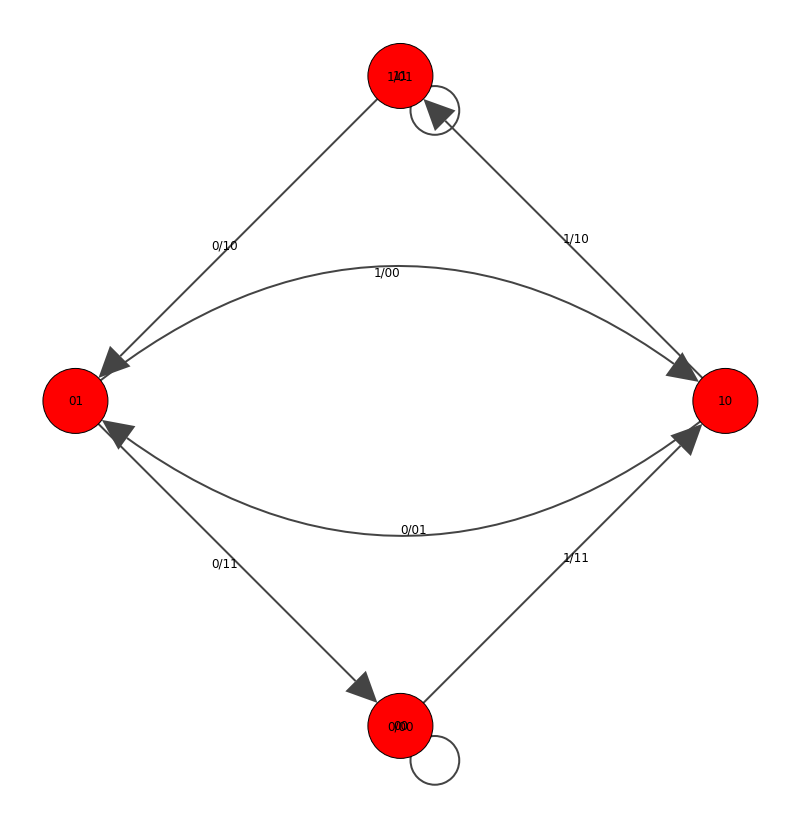

In [ ]:
sd = conv_state_diagram([[5],[7]])
layout = [(0,0),(-1,1),(1,1),(0,2)]
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
ig.plot(sd,vertex_label=sd.vs["name"], edge_label=sd.es["name"],target=plt.axes(), layout=layout,vertex_size=0.2)
# I don't know how to fix the fact that the edge labels of the self-loops are plotted in the vertex, overlapping with the vertex label. Anyone?

Now to build a trellis from the state diagram. This is a bit harder than just copying the state diagram at every turn because it's essential to include the build-up for the root for the susequent decoding algorithms to work. Termination is not important and would be difficult to programme so we left it out. In fact, once we have a Viterbi algorithm up we will discover a simple way to remove the nodes that are never attained for a terminated trellis so we will come back to this.  

In [ ]:
def sd2trellis(sd, n_stages):
  td = ig.Graph(directed=True)
  root = td.add_vertex(sd.vs[0]['name'])
  root['stage'] = 0
  for stage in range(n_stages):
    stage_vertices = td.vs.select(stage=stage)
    for vertex in stage_vertices:
      sd_vertex = sd.vs.select(name=vertex['name'])
      sd_edges = sd.es.select(_source = sd_vertex[0])
      sd_targets = [edge.target for edge in sd_edges]
      for edge, target in zip(sd_edges,sd_targets):
        target_name = sd.vs[target]['name']
        if not list(td.vs.select(name=target_name, stage=stage+1)):
          new_vertex = td.add_vertex(target_name)
          new_vertex['stage'] = stage+1
          new_edge = td.add_edge(vertex, new_vertex)
        else:
          existing_vertex = td.vs.select(name=target_name,stage=stage+1)
          new_edge = td.add_edge(vertex, existing_vertex[0])
        new_edge['name'] = edge['name']
        new_edge['stage'] = stage
 
  return(td)

Let's try this function out and draw the resulting trellis. 

<AxesSubplot:>

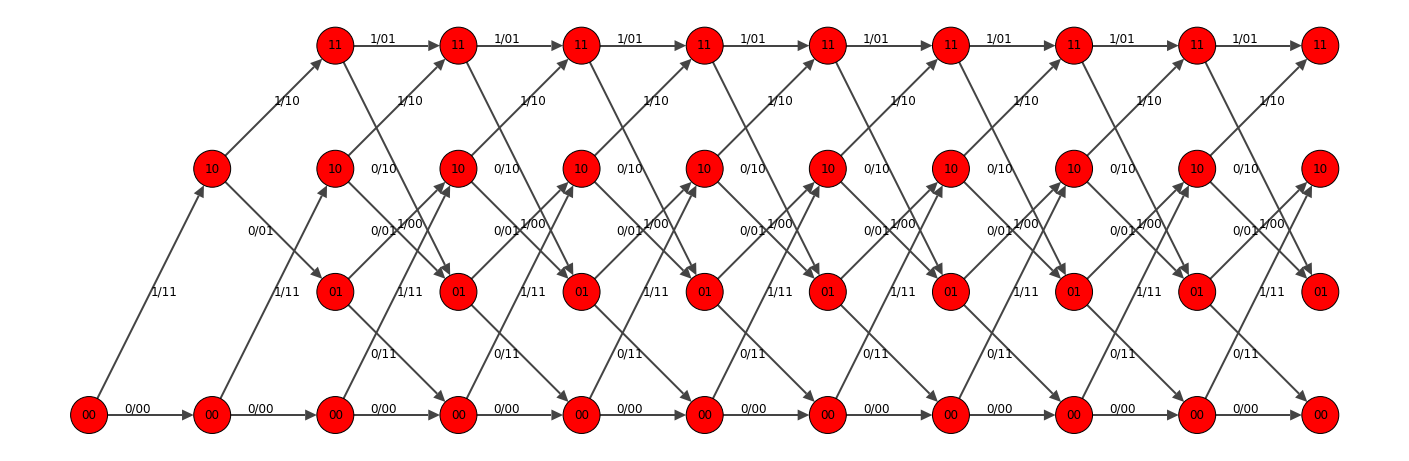

In [ ]:
td = sd2trellis(sd, 10)
layout = []
for vertex in td.vs.select():
  ypos = base2number([int(a) for a in vertex['name']],2)
  xpos = vertex['stage']
  layout.append((xpos,ypos))
f = plt.figure()
f.set_figwidth(25)
f.set_figheight(15)
ig.plot(td,vertex_label=td.vs["name"], edge_label=td.es["name"],target=plt.axes(), layout=layout,vertex_size=0.3)

## 3. TO BE COMPLETED: Symbolic computation of the graph transfer function

In this section, we will add a calculation of the graph transfer function to determine the distance profile of a convolutional code. 

In [ ]:
import sympy as sym

## 4. Decoders

To look into trellis-based decoders, we first need to transmit some data over a noisy channel. We generate random data and encode it with a convolutional encoder, say $(15,17)_8$. 

In [ ]:
import random as rand

data_length = 12
# conv code polynomials
p1 = [5] 
p2 = [7]
data = rand.getrandbits(data_length)
data = number2base(data,2,data_length)
codeword = conv_encode_list(data,[p1,p2])
# we rebuild the state diagram and trellis here to match the lengths (in case you fiddled with parameters in the first part of the lab)
sd = conv_state_diagram([p1,p2])
n_delays = len(sd.vs[0]['name'])
td = sd2trellis(sd, data_length+n_delays)

We want to test decoders over a range of channel, say binary erasure channels (BEC), binary symmetric channels (BSC), and a Binary-input Additive White Gaussian Noise (BiAWGN) channel.

In [ ]:
def Bernoulli(n,p):
  # ====> insert missing command here

def bec(x,p):
  n = len(x)
  e = Bernoulli(n,p)
  # =======> inser missing command here

def bsc(x,p):
  n = len(x)
  # =======> inser missing command here

def awgn(x,sigma):
  # =======> inser missing command here
  

print(bec(codeword,.3))
print(bsc(codeword,.3))
print(awgn([1-x*2 for x in codeword],.5))  

[0, 0, 1, 1, 1, 0, 0, 1, 1, '?', 0, '?', 0, '?', 1, '?', '?', '?', 1, 0, 0, '?', 0, '?', '?', '?', 1, 1]
[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1]
[1.7065136022804914, 0.7829584446216828, -0.7587861636388814, 0.021863566105261523, -1.0560803067650384, 1.449673217994893, 0.6092760661549419, -1.364857556754249, -0.5678864095694034, 1.1927797747598767, 1.3252201276052762, 0.5331518556867716, 0.337920473521492, -0.6590162860948396, -1.275848498354593, -1.7731346192613917, -1.620787531125785, -1.9797290921962534, 0.011285274165289572, 0.06823840576381657, 1.0847133338557033, -1.8689025585102916, 1.161208074123234, -1.3705859436820407, -1.3649869932321923, 0.5618444630820869, -0.3517646359532769, -0.6526358948797777]


We now build a Viterbi decoder. The Viterbi decoder best works in the logarithmic domain with an additive metric proportional to $-\log P(y|x)$, so that it turns into an algorithm that searches for the minimum metric path in order to achieve maximum likelihood. The algorithm has 3 phases:
* first we assign a metric $\gamma$ to every edge in the trellis
* then, we run the actual algorithm that computes metrics for the vertices by adding edge metrics to the metric of their originating vertex, and selecting the path of minimum metric when paths merge
* finally, we retrace our step backward to extract the minimum metric path.

We will consider a rooted and terminated trellis, since we returned our encoder to the zero state. This means that certain edges vertices in the trellis we drew earlier will never be visited by the decoder if they are not on a path from the root to the toor, but there is no harm in computing edge metrics for those edges in phase 1. 

Note that I am capitalising Viterbi because I've met Andy Viterbi many times and although he is a fantastic engineer with much to his credit, and inventing this algorithm has certainly boosted his position in the history of telecommunications to a phenomenal dimension, I nevertheless don't feel completely comfortable in reducing his name to a lower-case object as if he were a household item like a hoover. If you haven't met Andy and prefer to think of "viterbi" as a quirky name for an algorithm rather than his surname, you are more than welcome to edit the function name below and remove the stylistic clash in python naming conventions. (Note that I also capitalised "Bernoulli" although I obviously never met him, but I do feel a special connection with him on account of our shared citizenship....)

In [ ]:
def Viterbi(y, td, channel='bsc'):
  # phase 1: compute gammas
  N = len([int(a) for a in td.es[0]['name'][2:]]) # code rate 1/N
  for edge in td.es.select():
    edge_output = [int(a) for a in edge['name'][2:]]
    y_pos = edge['stage']*N
    y_slice = y[y_pos:y_pos+N]
    if channel == 'bsc':
      # ======> insert missing command here
    elif channel == 'bec':
      diff = [0 if (b=='?' or a == b) else 1 for a,b in zip(edge_output, y_slice)]
      if sum(diff) == 0:
        edge['gamma'] = 0
      else: 
        edge['gamma'] = 1 # 1 is infinity for the BEC!
    elif channel == 'awgn':
      modulated_output = [1-2*a for a in edge_output]
      # ======> insert missing command here

  # phase 2: compute alphas
  # This phase can be implemented in a purely "forward" way if you are confident
  # of being able to visit your vertices in an order that will only ever visit 
  # a vertex when all of its incoming edges are connected to vertices whose 
  # alpha have already been computed. The approach implemented here is a bit
  # different and was suggested to me by my 4th year project student
  # Omar Zaman: we start from the TOOR and operate a "stack" of nodes that
  # we are unable to compute. For the node at the top of the stack, we check
  # if its incoming neighbours have already been resolved. If yes, we resolve
  # the node and remove it from the stack. If not, on the other hand, then
  # we add the incoming neighbours to the stack.
  for vertex in td.vs.select():
    vertex['alpha'] = -1 # initialise all vertices to -1
  state_length = len(td.vs[0]['name'])
  root = td.vs.select(name='0'*state_length,stage=0)
  toor = td.vs.select(name='0'*state_length,stage=len(y)/N)
  root[0]['alpha'] = 0 # initialise root vertex to 0
  vstack = [toor[0].index]
  while vstack:
    cnode = vstack[-1]
    incoming = td.es.select(_target=cnode)
    if not list(incoming):
      vstack.pop()
      continue
    sources = [a.source for a in incoming]
    source_alphas = td.vs[sources]['alpha']
    if all([x == -1 for x in source_alphas]):  # all origins are uncomputed
      for a in incoming:
        vstack.append(a.source)
    else: # some origins computed, node can be resolved
      min_alpha = -1
      winner = -1
      for a in incoming:
        a['winner'] = 'loser' # preset all incoming to losing
        # ======> missing command here
        if min_alpha == -1 or candidate_alpha < min_alpha:
          winner = a
          min_alpha = candidate_alpha
      td.vs[cnode]['alpha'] = min_alpha
      winner['winning'] = 'winner' # record the winning incoming
      vstack.pop() # delete vertex from stack

  # phase 3: backtrack to read out the winning path and metric
  cnode = toor[0];
  decoded = []
  while (cnode['stage'] > 0):
    winner = td.es.select(_target=cnode.index, winning='winner')
    decoded.append(int(winner[0]['name'][0]))
    cnode = td.vs[winner[0].source]
  decoded.reverse()
  min_metric = toor[0]['alpha']
  return decoded, min_metric



In [ ]:
y = bsc(codeword, .1)
decoded,hamming_distance = Viterbi(y,td,'bsc')
print(f'Codeword:         {codeword}')
print(f'Transmitted word: {y}\n')
print(f'Encoded data:                        {data}')
print(f'Decoded word (with termination bits: {decoded}\n')
print(f'Hamming Distance: {hamming_distance}')

Codeword:         [0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]
Transmitted word: [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]

Encoded data:                        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1]
Decoded word (with termination bits: [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0]

Hamming Distance: 3


We can nicely visualise the operation of the Viterbi algorithm by labeling nodes with the $\alpha$ values and edges with their $\gamma$ values.

<AxesSubplot:>

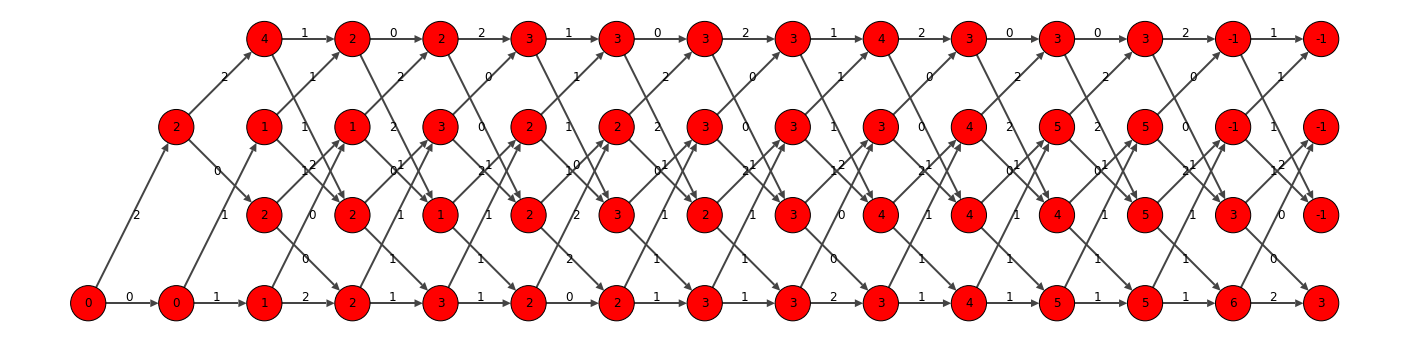

In [ ]:
layout = []
for vertex in td.vs.select():
  ypos = base2number([int(a) for a in vertex['name']],2)
  xpos = vertex['stage']
  layout.append((xpos,ypos))
f = plt.figure()
f.set_figwidth(25)
f.set_figheight(15)
ig.plot(td,vertex_label=td.vs["alpha"],edge_label=td.es['gamma'],target=plt.axes(), layout=layout,vertex_size=0.4)

Note now that the nodes not visited by the Viterbi algorithm have a label of -1. We can search for these nodes and amend our terminated trellis to include only relevant nodes (although the inclusion of the extra nodes did not interfere with the operation of the Viterbi algorithm and also won't interfere with the BCJR so this is optional.)

In [ ]:
def clean_trellis_after_Viterbi(td):
  useless_vertices = td.vs.select(alpha=-1)
  for vertex in useless_vertices:
    incoming = td.es.select(_target=vertex)
    td.delete_edges(incoming)
  td.delete_vertices(useless_vertices)

<AxesSubplot:>

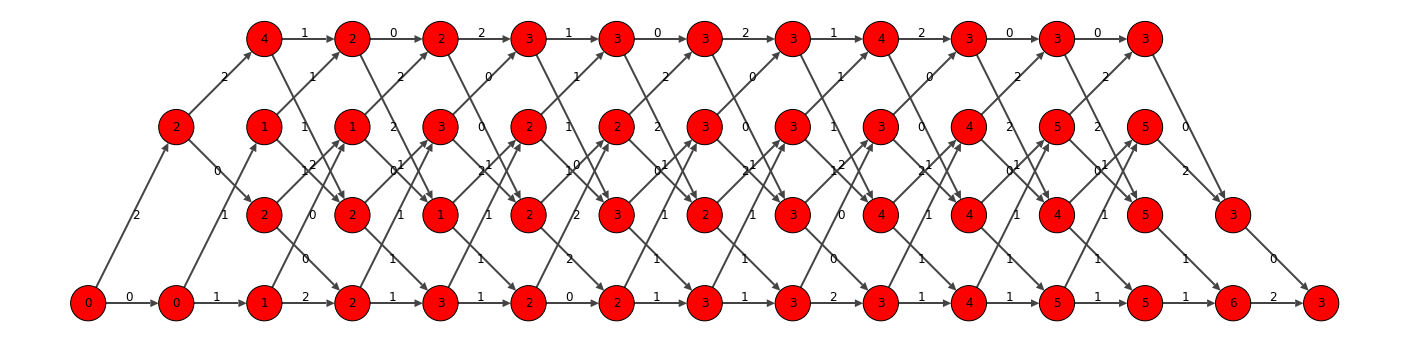

In [ ]:
clean_trellis_after_Viterbi(td)
layout = []
for vertex in td.vs.select():
  ypos = base2number([int(a) for a in vertex['name']],2)
  xpos = vertex['stage']
  layout.append((xpos,ypos))
f = plt.figure()
f.set_figwidth(25)
f.set_figheight(15)
ig.plot(td,vertex_label=td.vs["alpha"],edge_label=td.es['gamma'],target=plt.axes(), layout=layout,vertex_size=0.4)


We can now try decoding for other channels.

In [ ]:
y = bec(codeword, .2)
decoded, metric = Viterbi(y,td,'bec')
print(f'Codeword:         {codeword}')
print(f'Transmitted word: {y}\n')
print(f'Encoded data:                        {data}')
print(f'Decoded word (with termination bits: {decoded}\n')
if metric == 0:
  print('Decoding successful (but may not be correct)')
else:
  print('Illegal BEC behaviour!')

Codeword:         [0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]
Transmitted word: [0, '?', 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, '?', 1, 1, 1, '?', 1, 0, 0, 1, '?', 1, 1, 0, 1, 1]

Encoded data:                        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1]
Decoded word (with termination bits: [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0]

Decoding successful


In [ ]:
y = awgn([1-x*2 for x in codeword],.8)
decoded, squared_distance = Viterbi(y,td,'awgn')
print(f'Codeword:         {codeword}')
print(f'Transmitted word: {y}\n')
print(f'Encoded data:                        {data}')
print(f'Decoded word (with termination bits: {decoded}\n')
print(f'Squared Euclidean Distance: {squared_distance}')

Codeword:         [0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]
Transmitted word: [1.187391365569979, 1.4613013084327182, -0.5538056922804401, -0.9235849757097703, -2.009253394631309, 0.626886643077148, 1.279774276374753, -1.5205064778652098, -0.08586528489780121, 0.9895779599112641, -0.5842657923453354, 2.5360133088072976, 0.9607583926664867, -1.0743644239506738, -1.8763102435351402, -0.14025476237139867, -1.329672360488414, -2.0725646798726443, -0.47071324613403176, 1.8193713019199018, 0.9969242193387018, -1.9245212135931888, 0.009517301494249786, -0.8055389794240021, -1.3001093123411729, -0.42359634737703744, 0.1637097835298651, -1.846740618834184]

Encoded data:                        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1]
Decoded word (with termination bits: [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0]

Squared Euclidean Distance: 17.45108198875624


Now for the Bahl Cocke Jelinek Raviv (BCJR) algorithm implementation...  Unlike the Viterbi algorithm (that reduced to a minimisation of a metric that doesn't depend on the channel paramaters for the channels we considered), the BCJR will need to take those into account. Like the Viterbi, the BCJR has 3 phases: 


1. Compute $\gamma$ for the edges depending the corresponding channel values, code digits and (new) channel parameter
2. Run the actual "forward backward" algorithm to compute the values $\alpha$ and $\beta$ for all the vertices
3. Summary phase where a-posteriori probabilites and/or decisions are taken for the individual symbol values

The 3rd phase of the BCJR algorithm is a lot richer in possibilities than the BCJR algorithm. The algorithm itself computes the a-posteriori probabity of each edge in the trellis given the observation vector. From that, one can compute a variety of metrics of interest such as the a-posteriori probability of each code digit, the a-posteriori probability of each data symbol, or other relevant summaries depending on the application. In this lab, we will limit ourselves to computing a-posteriori probabilities for the information symbols and taking optimal symbol-wise decisions about them. 

We can try a first draft using just sums and products, bearing in mind that while this might work for small data blocklengths, it's likely to fail as the data length gets larger as the numbers involved in the sums become increasingly small. We will hence then need to develop a BCJR that operates in the logarithmic domain. In any case, we will use numpy in this implementation as the calculations are more sensitive.


In [ ]:
import numpy as np

def draft_bcjr(y, td, channel='bsc', parameter=0.1):
  # phase 1: compute gammas
  N = len([int(a) for a in td.es[0]['name'][2:]]) # code rate 1/N
  for edge in td.es.select():
    edge_output = [int(a) for a in edge['name'][2:]]
    y_pos = edge['stage']*N
    y_slice = y[y_pos:y_pos+N]
    if channel == 'bsc':
      hamming_distance = sum([int(a != b) for a,b in zip(edge_output, y_slice)])
      edge['gamma'] = np.power(parameter, hamming_distance)*np.power(1-parameter,N-hamming_distance)
    elif channel == 'bec':
      count_erasures = sum([1 if a=='?' else 0 for a in y_slice])
      count_differences = sum([1 if (b != '?' and a != b) else 0 for a,b in zip(edge_output, y_slice)])
      if (count_differences > 0):
        edge['gamma'] = 0
      else:
        edge['gamma'] = np.power(parameter, count_erasures)*np.power(1-parameter, N-count_erasures)
    elif channel == 'awgn':
      modulated_output = np.array([1-2*a for a in edge_output])
      squared_distance = np.sum(np.power(y_slice - modulated_output,2))
      edge['gamma'] = np.exp(-squared_distance/np.power(parameter,2))/np.sqrt(2*np.pi())/parameter

  # phase 2: run the forward backward algorithm
  for vertex in td.vs.select():
    vertex['alpha'] = 0 # initialise all vertices to 0
    vertex['beta'] = 0 # initialise all vertices to 0
  state_length = len(td.vs[0]['name'])
  root = td.vs.select(name='0'*state_length,stage=0)
  toor = td.vs.select(name='0'*state_length,stage=len(y)/N)
  root[0]['alpha'] = 1 # initialise root alpha to 1
  toor[0]['beta'] = 1 # initialise toor beta to 1
  # forward
  for stage in range(1,toor[0]['stage']+1):
    for vertex in td.vs.select(stage=stage):
      for incident in td.es.select(_target=vertex):
        vertex['alpha'] += incident['gamma']*td.vs[incident.source]['alpha']
  # backward
  for stage in range(toor[0]['stage']-1,-1,-1):
    for vertex in td.vs.select(stage=stage):
      for incident in td.es.select(_source=vertex):
        vertex['beta'] += incident['gamma']*td.vs[incident.target]['beta']
  # now to multiply the alphas, betas and gammas
  for edge in td.es.select():
    edge['gamma'] *= td.vs[edge.source]['alpha']*td.vs[edge.target]['beta']

  # Phase 3: summarise data symbol probabilities
  app = []
  decoded = []
  for stage in range(toor[0]['stage']):
    sum0 = 0
    sum1 = 0
    for edge in td.es.select(stage=stage):
      if edge['name'][0] == '0':
        sum0 += edge['gamma']
      else:
        sum1 += edge['gamma']
    app.append(np.log(sum0/sum1))
    decoded.append(int(app[-1] < 0))
  
  return app, decoded


In [ ]:
y = bsc(codeword, .1)
app, decoded = draft_bcjr(y,td,'bsc',.1)
print(f'Codeword:         {codeword}')
print(f'Transmitted word: {y}\n')
print(f'Encoded data:                        {data}')
print(f'Decoded word (with termination bits: {decoded}\n')
print(f'A-posteriori log-likelihoods: {app}')



Codeword:         [0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]
Transmitted word: [0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]

Encoded data:                        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1]
Decoded word (with termination bits: [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0]

A-posteriori log-likelihoods: [10.734871669314515, -10.629546045910121, -10.52424590862269, -10.503460916616751, 10.490647005620618, -10.487558335219253, 10.487558335219253, 10.490647005620618, -10.503460916616751, -10.52424590862269, -10.629546045910121, -10.734871669314515, inf, inf]


<ipython-input-21-d711d36280cc>:59: RuntimeWarning: divide by zero encountered in double_scalars
  app.append(np.log(sum0/sum1))


This works fairly well for a data length of 12 and a simple convolutional encoder, but if you try to run it for longer data and a larger encoder (with longer polynomials / more states) you are likely to see a severe degradation of performance due to the numerical issue of taking sums of ever smaller numbers. This can be fixed by implementing a logarithmic version of the algorithms. Products of probabilities become sum of logarithms, which is a lot easier and nuermically stable. However, for the sums needed to compute the $\alpha$ and $\beta$ parameters, we resort to the so called "log-max" rule

$$ \log (e^{\lambda_1} + e^{\lambda_2}) =  \log\left[ e^{\lambda_1}(1+e^{\lambda_2-\lambda_2})\right] = \lambda_1 + \log(1+e^{-\Delta})$$

where $\Delta = \lambda_1-\lambda_2$, $\lambda_1 = \log p_1$ and $\lambda_2=\log p_2$, so the rule computes the sum of the probabilities starting from the log domain and returns to the log domain after performing the sum. The rule is numerically stable if $\lambda_1>>\lambda_2$ at which point the maximum by itself is already a good approximation and the correction term $\log(1+e^{-\Delta}$ is small. Hence the rule can be re-written (as in the 3F4 lecture notes) as

$$\log(e^x+e^y) = \max(x,y) + \log(1+e^{-\Delta})$$
where $\Delta = \max(x,y)-\min(x,y)$. 

In [ ]:
def logmax(x,y):
  return(max(x,y)+ np.log(1+np.exp(min(x,y)-max(x,y))))  
  
# this can be applied recursively to lists
def logmaxlist(x): 
  if len(x) == 2:
    return(logmax(x[0],x[1]))
  else: 
    return(logmax(x[0],logmaxvec(x[1:])))

Now we can implement a logarithmic BCJR that should be numerically more stable. 

In [ ]:
def log_bcjr(y, td, channel='bsc', parameter=0.1):
  # phase 1: compute gammas
  N = len([int(a) for a in td.es[0]['name'][2:]]) # code rate 1/N
  for edge in td.es.select():
    edge_output = [int(a) for a in edge['name'][2:]]
    y_pos = edge['stage']*N
    y_slice = y[y_pos:y_pos+N]
    if channel == 'bsc':
      hamming_distance = sum([int(a != b) for a,b in zip(edge_output, y_slice)])
      edge['gamma'] = hamming_distance * np.log(parameter)+(N-hamming_distance)*np.log(1-parameter)
    elif channel == 'bec':
      count_erasures = sum([1 if a=='?' else 0 for a in y_slice])
      count_differences = sum([1 if (b != '?' and a != b) else 0 for a,b in zip(edge_output, y_slice)])
      if (count_differences > 0):
        edge['gamma'] = float('-inf')
      else:
        edge['gamma'] = count_erasures*np.log(parameter) + (N-count_erasures)*np.log(1-parameter)
    elif channel == 'awgn':
      modulated_output = np.array([1-2*a for a in edge_output])
      squared_distance = np.sum(np.power(y_slice - modulated_output,2))
      edge['gamma'] = -squared_distance/np.power(parameter,2) - np.log(2*np.pi)/2-np.log(parameter)

  # phase 2: run the forward backward algorithm
  state_length = len(td.vs[0]['name'])
  root = td.vs.select(name='0'*state_length,stage=0)
  toor = td.vs.select(name='0'*state_length,stage=len(y)/N)
  root[0]['alpha'] = 0 # initialise root alpha to 0 (log 1)
  toor[0]['beta'] = 0 # initialise toor beta to 0
  # forward
  for stage in range(1,toor[0]['stage']+1):
    for vertex in td.vs.select(stage=stage):
      incident = td.es.select(_target=vertex)
      if len(incident) == 1:
        vertex['alpha'] = incident[0]['gamma'] + td.vs[incident[0].source]['alpha']
      elif len(incident) == 2:
        gamma_alpha_0 = incident[0]['gamma']+td.vs[incident[0].source]['alpha']
        gamma_alpha_1 = incident[1]['gamma']+td.vs[incident[1].source]['alpha']
        vertex['alpha'] = logmax(gamma_alpha_0, gamma_alpha_1)
      else:
        raise NameError('A vertex with no or more than 2 incident edges has been found')        
  # backward
  for stage in range(toor[0]['stage']-1,-1,-1):
    for vertex in td.vs.select(stage=stage):
      incident = td.es.select(_source=vertex)
      if len(incident) == 1:
        vertex['beta'] = incident[0]['gamma']+td.vs[incident[0].target]['beta']
      elif len(incident) == 2:
        gamma_beta_0 = incident[0]['gamma']+td.vs[incident[0].target]['beta']
        gamma_beta_1 = incident[1]['gamma']+td.vs[incident[1].target]['beta']
        vertex['beta'] = logmax(gamma_beta_0,gamma_beta_1)
  # now to "multiply" the alphas, betas and gammas by adding the logs
  for edge in td.es.select():
    edge['gamma'] += td.vs[edge.source]['alpha']+td.vs[edge.target]['beta']

  # Phase 3: summarise data symbol probabilities
  app = []
  decoded = []
  for stage in range(toor[0]['stage']):
    zero_edges = []
    one_edges = []
    for edge in td.es.select(stage=stage):
      if edge['name'][0] == '0':
        zero_edges.append(edge['gamma'])
      else:
        one_edges.append(edge['gamma'])
    if len(zero_edges) == 0:
      zero_log_max = float('-inf')
    elif len(zero_edges) == 1:
      zero_log_max = zero_edges[0]
    else:
      zero_log_max = logmaxlist(zero_edges)
    if len(one_edges) == 0:
      one_log_max = float('-inf')
    elif len(one_edges) == 1:
      one_log_max = one_edges[0]
    else:
      one_log_max = logmaxlist(one_edges)
    app.append(zero_log_max - one_log_max)
    decoded.append(int(app[-1] < 0))
  
  return app, decoded

In [ ]:
y = bsc(codeword, .1)
app, decoded = log_bcjr(y,td,'bsc',.1)
print(f'Codeword:         {codeword}')
print(f'Transmitted word: {y}\n')
print(f'Encoded data:                        {data}')
print(f'Decoded word (with termination bits: {decoded}\n')
print(f'A-posteriori log-likelihoods: {app}')


Codeword:         [0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]
Transmitted word: [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]

Encoded data:                        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1]
Decoded word (with termination bits: [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0]

A-posteriori log-likelihoods: [8.469384060443907, -7.866475420267429, -6.365495139659892, -6.327224197945227, 6.325995275665603, -7.730405323315859, 8.223113043589343, 9.211950336142081, -9.694752372312628, -10.169305634402333, -10.459286888371723, -10.669131074736812, inf, inf]


##5. TO BE COMPLETED: Looking further

In this section, we will look at:
* implementations of Viterbi and the BCJR for channels with insertions and deletions (with applications to DNA alignment)
* extending our encoder and decoder framework to recursive systematic encoders
* implementing puncturing and incorporating puncturing in the decoders
* Turbo coding / decoding